## Information Extraction Functions
#### Work in Progress

This `.ipynb` file is to hold code that has been cleaned up & ready to share with the team. This will help us conform to using the same form when storing data, etc. 

It also contains useful code snippets that we feel other team members may find useful when they are working on their own.

In [2]:
from collections import defaultdict
import re

#### Rule-Based Information Parsing

In [68]:
def rule_based_parse_BCJ(doc):
    '''Given an entire case, finds static information within the case (information that can be pattern matched)
    Expects a B.C.J. case format (British Columbia Judgments)
    The following fields are currently implemented:
    - Case Title
    - Judge Name
    - Registry
    - Year
    - Decision Length (in paragraphs)
    The following fields are still being implemented & tweaked:
    - Multiple Defendants
    Arguments: doc (String): The case in text format following the form used in the DOCX to TXT notebook
    Returns: case_dict (Dictionary): Dictionary with rule based parsable fields filled in
    '''
    lines = doc.split('\n')
    case_dict = dict() 
    # Fields that can be found via pattern matching
    decision_len = re.search(r'\(([0-9]+) paras\.?\)', doc) # e.g.) (100 paras.)
    registry = re.search(r'(Registry|Registries): ?([A-Za-z0-9 ]+)', doc) # e.g.) Registry: Vancouver
    if registry:
        registry = registry.group(2).strip()
    else:
        registry = re.search(r'([A-Za-z ]+) Registry No.', doc) # Alt form e.g.) Vancouver Registory No. XXX
        if registry:
            registry = registry.group(1).strip()
        else:
            registry = re.search(r'([A-Za-z ]+) No. S[0-9]*', doc)
            if registry:
                registry = registry.group(1).strip()
            else:
                print('WARNING: Registry could not be found (This shouldn\'t occur!)')
    # Fields that are always in the same place
    judge_name = lines[4].strip()
    case_title = lines[0].strip()
    # Extract year from case_title (in case we want to make visualizations, etc.)
    year = re.search(r'20[0-2][0-9]', case_title) # Limit regex to be from 2000 to 2029
    if year:
        year = year.group(0)
    else:
        # Rare case: Sometimes the title is too long. Rely on Heard date.
        year = re.search(r'Heard:.* ([2][0][0-2][0-9])', doc)
        if year:
            year = year.group(1)
        else:
            print('WARNING: Year not found')
    case_dict['case_title'] = case_title
    case_dict['year'] = year
    case_dict['registry'] = registry
    case_dict['judge'] = judge_name
    case_dict['decision_length'] = decision_len.group(1)
    case_dict['multiple_defendants'] = rule_based_multiple_defendants_parse(doc)
    return case_dict

In [69]:
def rule_based_multiple_defendants_parse(doc):
    ''' Work in progress. Subject to minor changes to Regex patterns.
    
    TODO:
        - Clarify solicitor/client cases with Lachlan
        - Clarify cases that say "IN MATTER OF ...", currently returning 'UNK' for these
    
    -----
    
    Given a case. Uses regex/pattern-matching to determine whether we have multiple defendants.
    For the most part the logic relies on whether the langauge used implies plurality or not.
    
    Arguments: doc (String): The case in text format following the form used in the DOCX to TXT notebook
    Returns: response (String, 'Y', 'N', or 'UNK')
    
    '''
    
    # Cases with (Re) in the title always have one person involved
    # May drop these cases depending on advice from Lachlan.
    if '(Re)' in doc.split('\n')[0]:
        return 'N'
    
    # Case 1)
    # Traditional/most common. Of form "Between A, B, C, Plaintiff(s), X, Y, Z Defendant(s)"
    # Can successfully cover ~98% of data
    regex_between_plaintiff_claimant = re.search(r'(Between.*([P|p]laintiff[s]?|[C|c]laimant[s]?|[A|a]ppellant[s]?|[P|p]etitioner[s]?).*([D|d]efendant[s]?|[R|r]espondent[s]?).*\n)', doc)
    
    # Match found
    if regex_between_plaintiff_claimant:
        text = regex_between_plaintiff_claimant.group(0).lower()
        if 'defendants' in text or 'respondents' in text:
            return 'Y'
        elif 'defendant' in text or 'respondent' in text:
            return 'N'
    
    # If not found, try other less common cases
    else:
        # Case 2)
        # Sometimes it does not mention the name of the second item. (Defendent/Respondent)
        # We can estimate if there are multiple based on the number of "," in the line (Covers all cases in initial data)
        regex_missing_defendent = re.search(r'(Between.*([P|p]laintiff[s]?|[C|c]laimant[s]?|[A|a]ppellant[s]?|[P|p]etitioner[s]?).*\n)', doc)
        if regex_missing_defendent:
            text = regex_missing_defendent.group(0).lower()
            if len(text.split(',')) > 5:
                return 'Y'
            else:
                return 'N'
            
        else:
            
            # Case 3A) solicitor-client
            # Some cases have a solicitor (lawyer) and a client
            # Currently assuming the second item is the defendant
            regex_solicitor_client = re.search(r'(Between.*([S|s]olicitor[s]?).*([C|c]lient[s]?))', doc)
            if regex_solicitor_client:
                text = regex_solicitor_client.group(0).lower()
                if 'clients' in text:
                    return 'Y'
                else:
                    return 'N'
            else:
                # Case 3B) client - solicitor
                regex_client_solicitor = re.search(r'(Between.*([C|c]lient[s]?).*([S|s]olicitor[s]?))', doc)
                if regex_client_solicitor:
                    text = regex_client_solicitor.group(0).lower()
                    if 'solicitors' in text:
                        return 'Y'
                    else:
                        return 'N'
                else:
                    return 'UNK'
        
        

#### Example of using above functions

Just putting parsed data from `P1.txt` into a list

In [70]:
with open('../data/Lexis Cases txt/P1.txt', 'r') as document:
    document_data = document.read()
        
document_data = document_data.split('End of Document\n') # Always split on 'End of Document\n'
case_parsed_data = []
for case in document_data:
    case = case.strip() # Make sure to strip!
    
    if len(case) == 0: # Skip empty lines
        continue
        
    case_title = case.split('\n')[0]
    case_type = case.split('\n')[1]
    
    if 'R. v.' in case_title: # Skip crown cases
        continue
    
    if 'British Columbia Judgments' in case_type: # Make sure we're dealing with a B.C.J. case
        case_parsed_data.append(rule_based_parse_BCJ(case))
        
case_parsed_data[-1]

{'case_title': 'Madill v. Sithivong, [2010] B.C.J. No. 2603',
 'year': '2010',
 'registry': 'Chilliwack',
 'judge': 'N.E. Morrison J.',
 'decision_length': '213',
 'multiple_defendants': 'Y'}

#### Data Statistics

Code snippets that may be useful for gathering some statistics about the data.

##### Necessary variables for code below

In [71]:
path_to_data = '../data/Lexis Cases txt/'
file_prefix = 'P'
file_suffix = '.txt'
file_identifiers = range(1, 86) # Range from 1 to 85

##### Cases by type counter

In [72]:
case_type_counts = defaultdict(int)

for file_number in file_identifiers:

    print('Processing ' + path_to_data + file_prefix + str(file_number) + file_suffix)

    with open(path_to_data + file_prefix + str(file_number) + file_suffix, 'r') as document:
        document_data = document.read()
        
    document_data = document_data.split('End of Document\n') # Must have \n as the phrase appears in one of the cases
    for case in document_data:
        case = case.strip()
        # Just in-case we have an empty case in the list
        if len(case) > 0:
            case_title = case.split('\n')[0]
            case_type = case.split('\n')[1]
            if 'R. v.' in case_title:
                case_type_counts['Crown Cases (R. v. ___)'] += 1
            elif 'Canadian Health Facilities Law Guide' in case_type: # CHFL
                case_type_counts['CHFL'] += 1
            elif 'British Columbia Judgments' in case_type: # B.C.J.
                case_type_counts['BCJ'] += 1
            elif 'Canadian Insurance Law Reporter Cases' in case_type: # I.L.R.
                case_type_counts['ILR'] += 1
            elif 'Canadian Commercial Law Guide' in case_type: # CCLG
                case_type_counts['CCLG'] += 1
            elif 'Ontario Corporations Law Guide' in case_type: # OCLG
                case_type_counts['OCLG'] += 1
            elif 'Canadian Corporate Secretary\'s Guide' in case_type: # CCSG
                case_type_counts['CCSG'] += 1
            elif 'Canadian Employment Benefits & Pension Guide' in case_type: # CBPG
                case_type_counts['CBPG'] += 1
            elif 'Alberta Corporations Law Guide' in case_type: # ACLG
                case_type_counts['ACLG'] += 1
            elif 'British Columbia Real Estate Law Guide' in case_type: # BREG
                case_type_counts['BREG'] += 1
            elif 'Canadian Native Law Reporter' in case_type: # C.N.L.R
                case_type_counts['CNLR'] += 1
            elif 'Dominion Tax Cases' in case_type: # DTC
                case_type_counts['DTC'] += 1
            elif 'Canadian Labour Law Reporter' in case_type: # CLLC
                case_type_counts['CLLC'] += 1
            elif 'British Columbia Corporations Law Guide' in case_type: # BCLG
                case_type_counts['BCLG'] += 1

Processing ../data/Lexis Cases txt/P1.txt
Processing ../data/Lexis Cases txt/P2.txt
Processing ../data/Lexis Cases txt/P3.txt
Processing ../data/Lexis Cases txt/P4.txt
Processing ../data/Lexis Cases txt/P5.txt
Processing ../data/Lexis Cases txt/P6.txt
Processing ../data/Lexis Cases txt/P7.txt
Processing ../data/Lexis Cases txt/P8.txt
Processing ../data/Lexis Cases txt/P9.txt
Processing ../data/Lexis Cases txt/P10.txt
Processing ../data/Lexis Cases txt/P11.txt
Processing ../data/Lexis Cases txt/P12.txt
Processing ../data/Lexis Cases txt/P13.txt
Processing ../data/Lexis Cases txt/P14.txt
Processing ../data/Lexis Cases txt/P15.txt
Processing ../data/Lexis Cases txt/P16.txt
Processing ../data/Lexis Cases txt/P17.txt
Processing ../data/Lexis Cases txt/P18.txt
Processing ../data/Lexis Cases txt/P19.txt
Processing ../data/Lexis Cases txt/P20.txt
Processing ../data/Lexis Cases txt/P21.txt
Processing ../data/Lexis Cases txt/P22.txt
Processing ../data/Lexis Cases txt/P23.txt
Processing ../data/L

### Data visualization

In [105]:
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import seaborn as sns
import pandas as pd

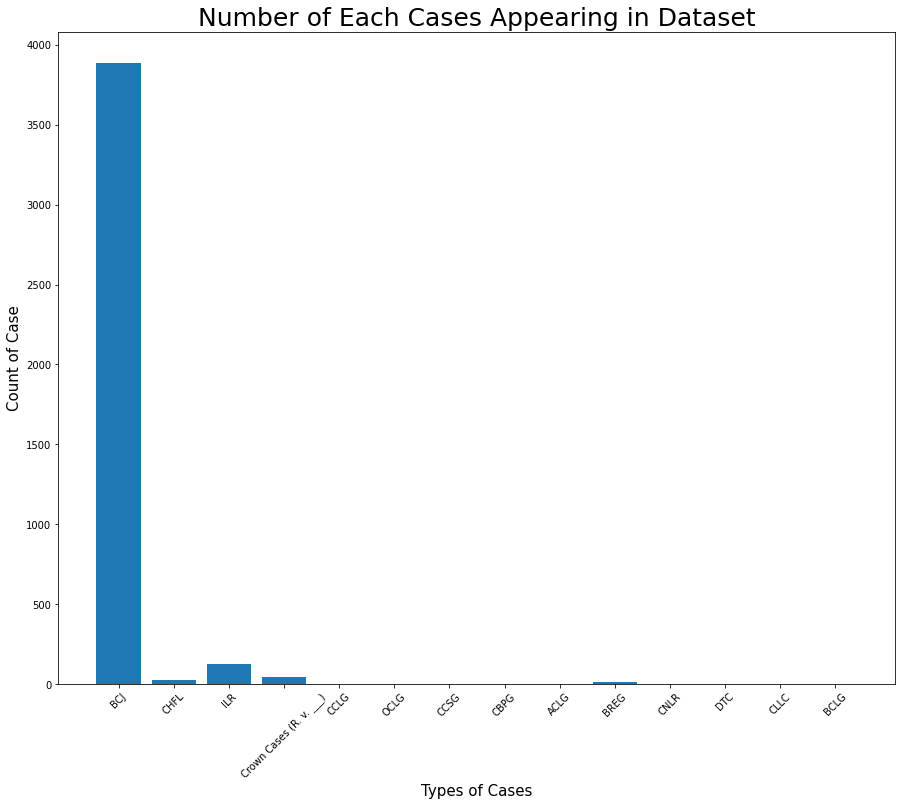

In [74]:
f1 = plt.figure(figsize=[15,12])
plt.bar(range(len(case_type_counts)), list(case_type_counts.values()), align='center')
plt.xticks(range(len(case_type_counts)), list(case_type_counts.keys()), rotation=45)
plt.ylabel('Count of Case', fontsize = '15' )
plt.xlabel('Types of Cases', fontsize = '15')
plt.title ('Number of Each Cases Appearing in Dataset', fontsize= '25')
plt.show()

In [75]:
path = "../data/Lexis Cases txt/"
list_of_files = os.listdir(path)


In [80]:
all_cases_parsed =[]
for files in list_of_files:
    if files != ".DS_Store":
        with open(path + files, 'r') as document:
            document_data = document.read()
        document_data = document_data.split('End of Document\n') # Always split on 'End of Document\n'
    for case in document_data:
        case = case.strip() # Make sure to strip!

        if len(case) == 0: # Skip empty lines
            continue

        case_title = case.split('\n')[0]
        case_type = case.split('\n')[1]

        if 'R. v.' in case_title: # Skip crown cases
            continue

        if 'British Columbia Judgments' in case_type: # Make sure we're dealing with a B.C.J. case
            all_cases_parsed.append(rule_based_parse_BCJ(case))
    

In [87]:
all_cases_parsed[1]

{'case_title': 'Beverly Corners Liquor Store Ltd. v. British Columbia (General Manager, Liquor Control and Licensing Branch), [2012] B.C.J. No. 2584',
 'year': '2012',
 'registry': 'Vancouver',
 'judge': 'J.R. Dillon J.',
 'decision_length': '46',
 'multiple_defendants': 'N'}

In [106]:
mult_def = []
years = []
for d in all_cases_parsed:
    for keys , values in d.items():
        if keys == 'multiple_defendants':
            mult_def.append(values)
        if keys == 'year':
            years.append(values)

In [117]:
df = pd.DataFrame({'multiple_defendants':mult_def})

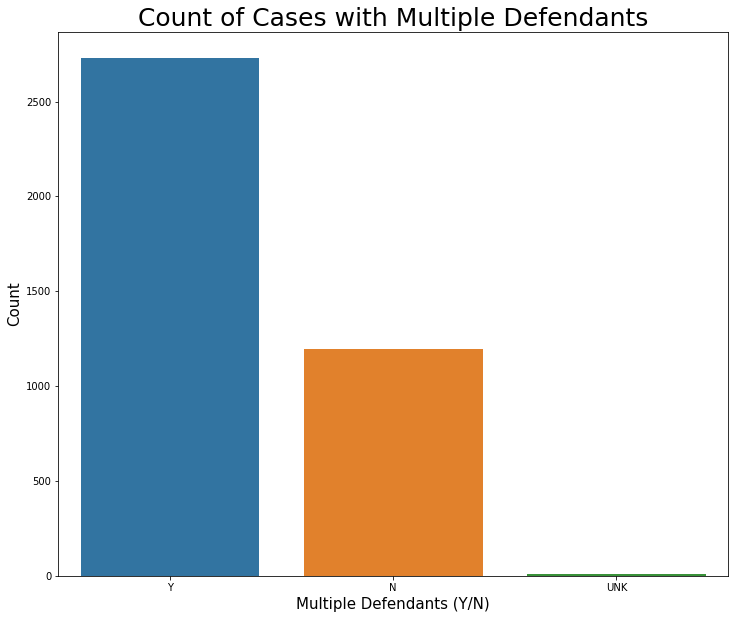

In [120]:
f1 = plt.figure(figsize=[12,10])
ax = sns.countplot(x="multiple_defendants", data=df)
plt.ylabel('Count', fontsize = '15' )
plt.xlabel('Multiple Defendants (Y/N)', fontsize = '15')
plt.title ('Count of Cases with Multiple Defendants', fontsize= '25')
plt.show()